In [1]:
import deepdish.io as io
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
d = h5py.File('../data/gamma.hdf5', 'r')

In [3]:
matplotlib.__version__ # should be 2.0.0

'2.0.0'

In [4]:
first = d['layer_0'][:]
second = d['layer_1'][:]
third = d['layer_2'][:]

In [5]:
sizes = [first.shape[1], first.shape[2], second.shape[1], second.shape[2], third.shape[1], third.shape[2]]

In [6]:
matplotlib.rcParams.update({'font.size': 50})

In [7]:
def plot_image(image, layer, vmin=None, vmax=None):
    fig = plt.figure(figsize=(20,20))
    plt.imshow(image, aspect=float(sizes[layer*2 + 1])/sizes[layer*2],
               interpolation='nearest', norm=LogNorm(vmin, vmax))
    cbar = plt.colorbar(fraction=0.0455)
    cbar.set_label(r'Energy (MeV)', y=0.83)
    cbar.ax.tick_params() #labelsize=30) 
   
    xticks = range(sizes[layer*2 + 1])
    yticks = range(sizes[layer*2])
    if layer == 0:
        xticks = xticks[::10]
    plt.xticks(xticks)#, fontsize=30)
    plt.yticks(yticks)
    plt.xlabel(r'$\eta$ Cell ID')
    plt.ylabel(r'$\phi$ Cell ID')

    plt.tight_layout()
    #return fig

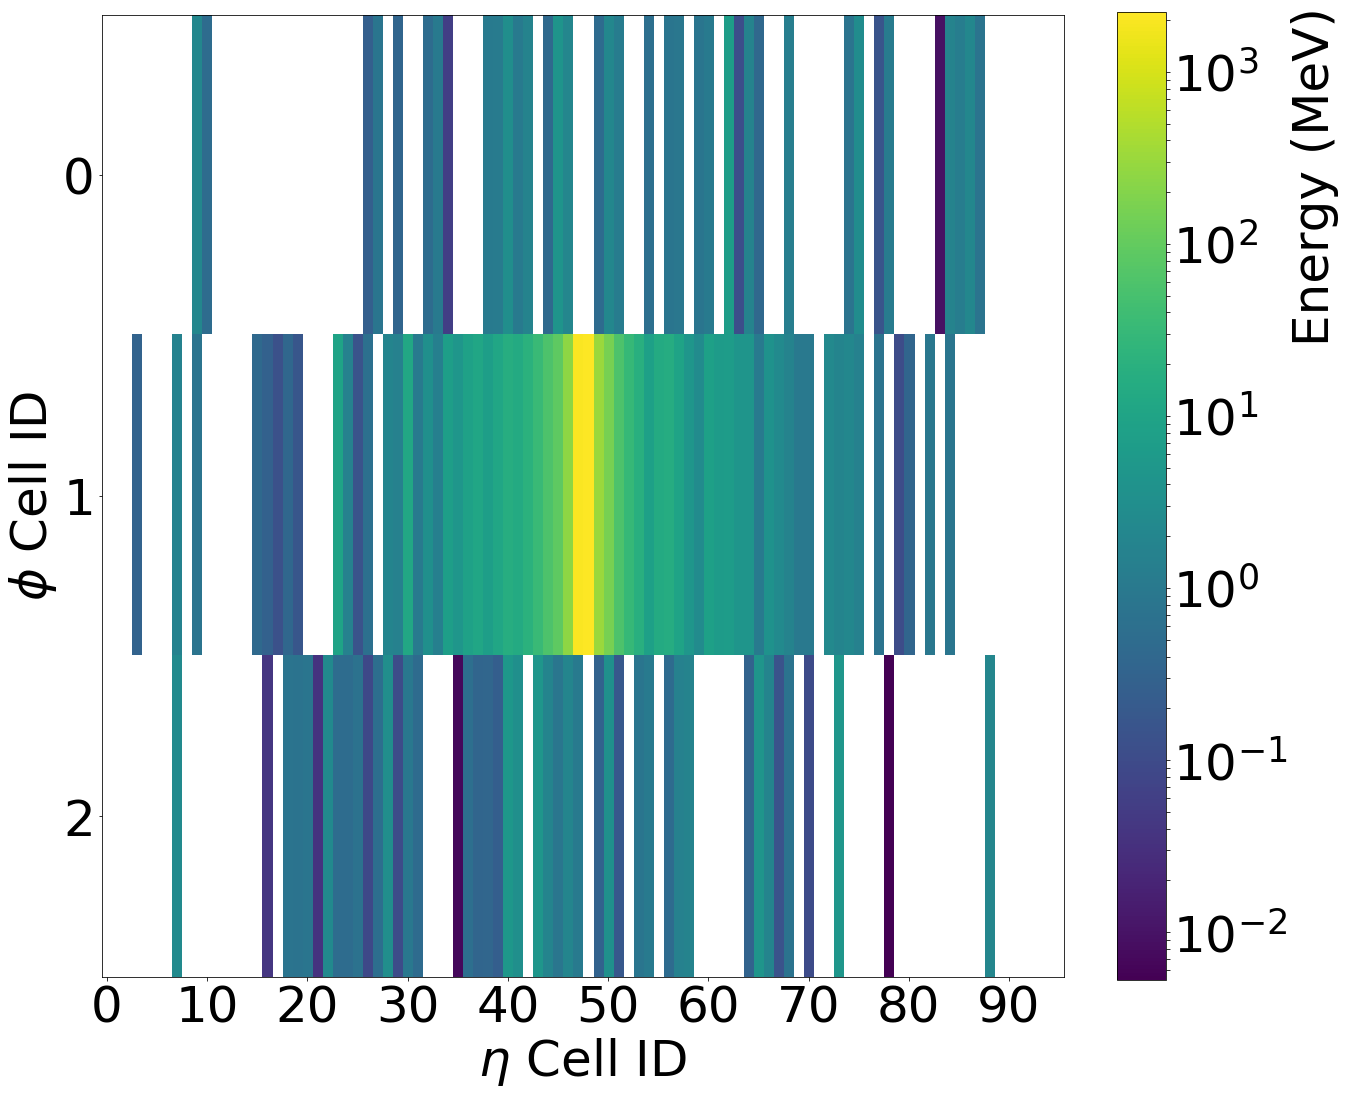

In [8]:
imageix = 0
# plt.figure(figsize=(20,20))
# plt.imshow(first[imageix], aspect=float(first.shape[2])/first.shape[1],
#            interpolation='nearest', norm=LogNorm())
# cbar = plt.colorbar(fraction=0.0455)
# cbar.set_label(r'Energy (MeV)', y=0.85)
# cbar.ax.tick_params()#labelsize=30) 
# plt.xticks(range(first.shape[2])[::10], fontsize=50)
# plt.yticks(range(first.shape[1]))
# plt.xlabel(r'$\eta$ Cell ID')
# plt.ylabel(r'$\phi$ Cell ID')

# plt.tight_layout()
# plt.savefig('0_1.png', transparent=True)
plot_image(first[imageix], layer=0)

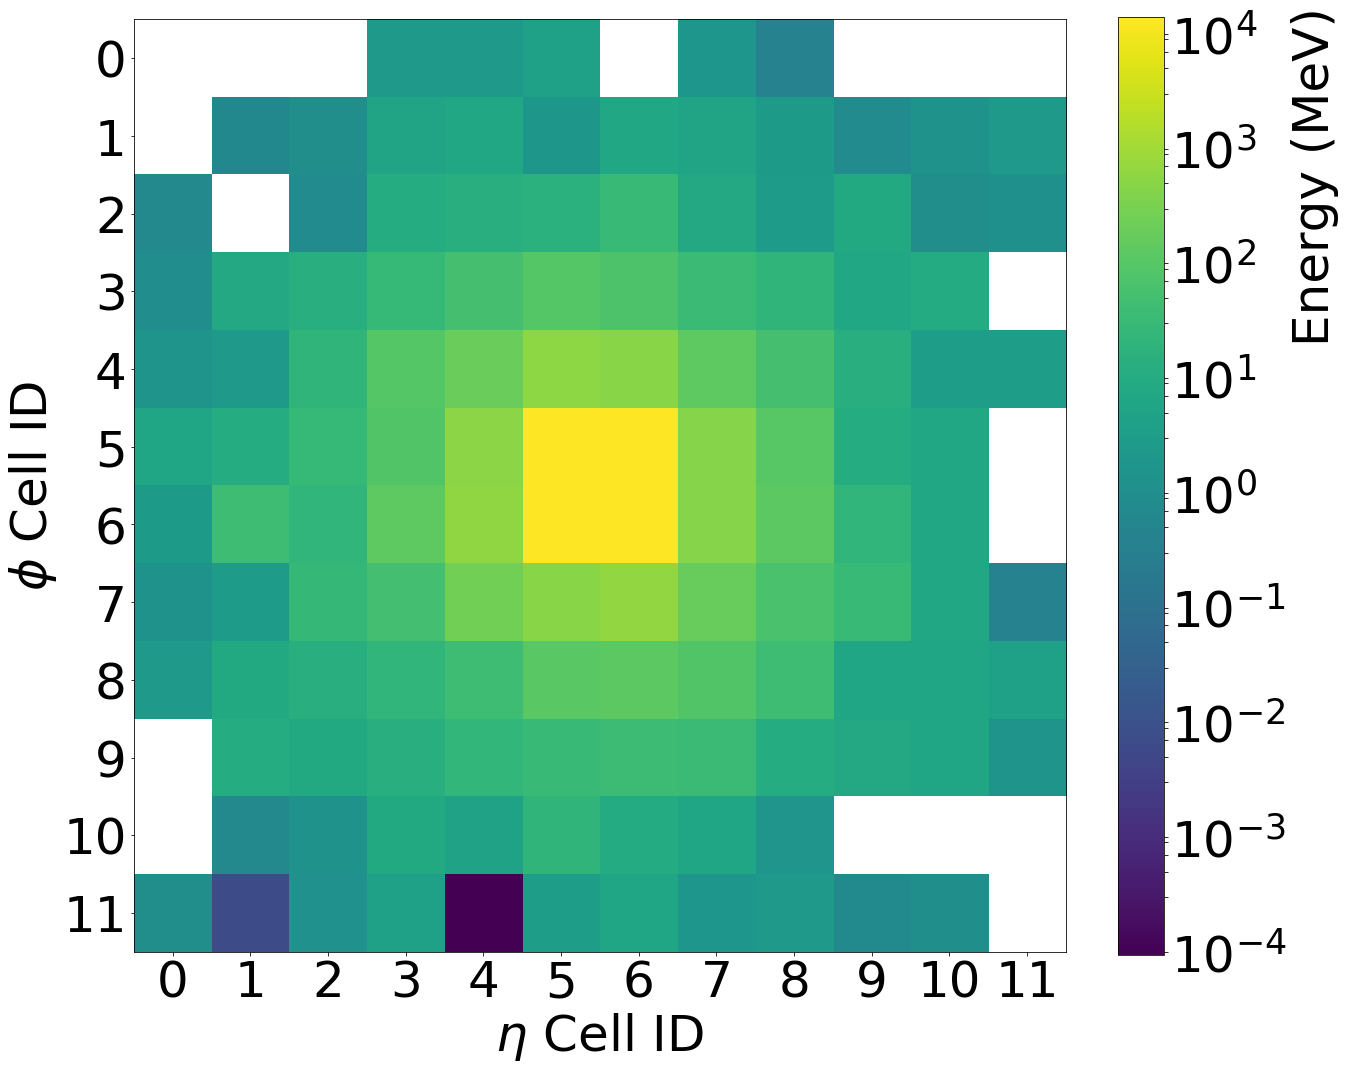

In [9]:
plot_image(second[imageix], layer=1)

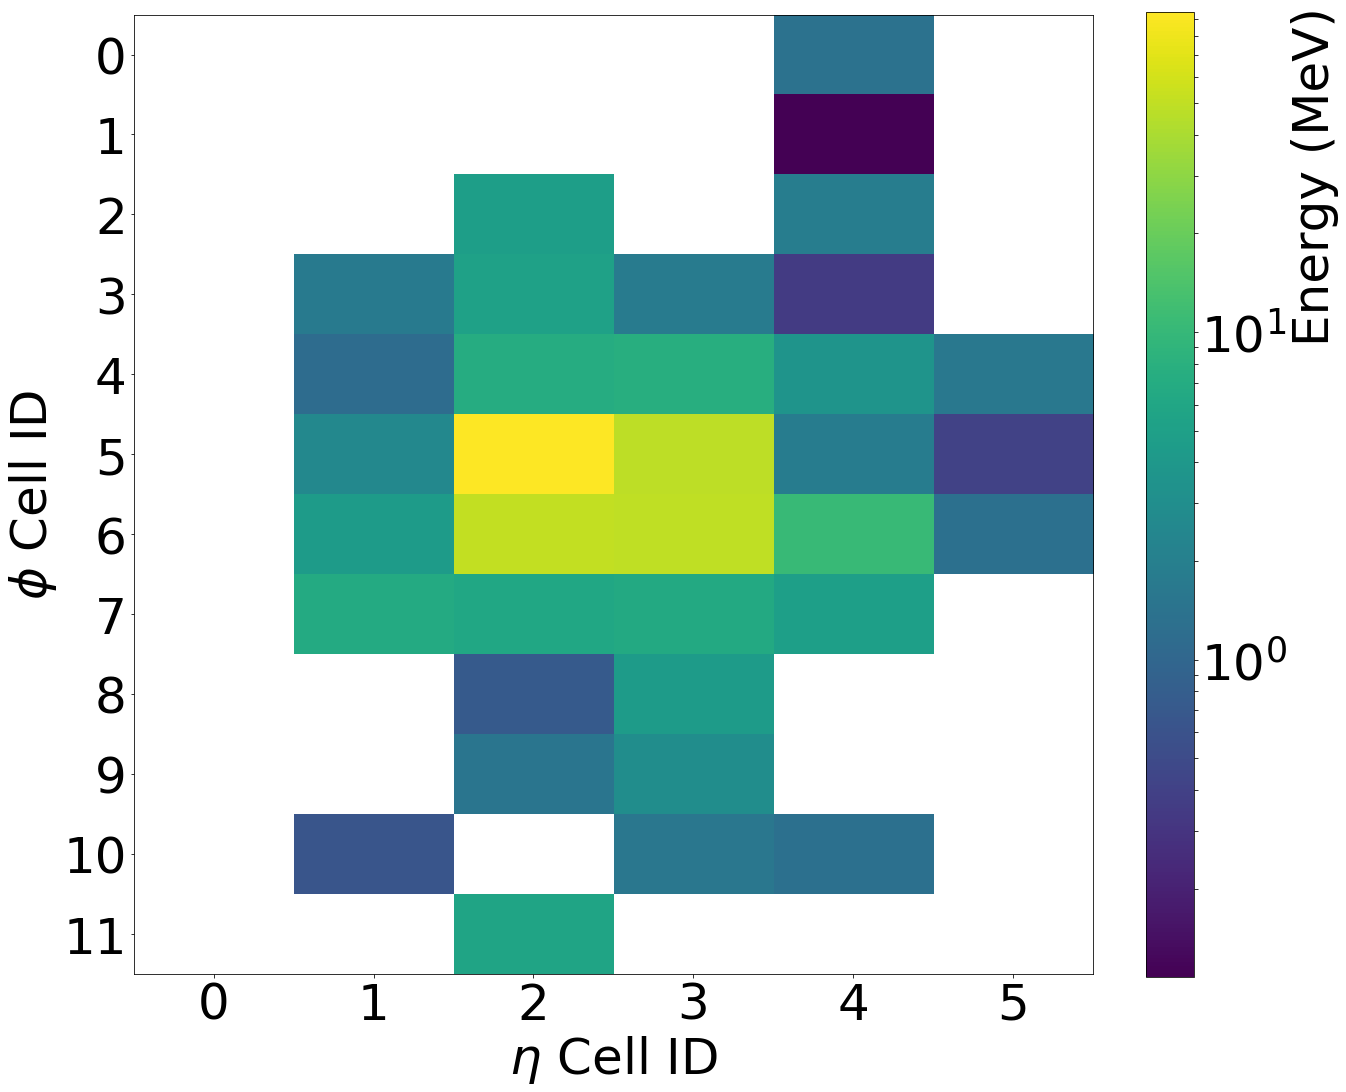

In [10]:
plot_image(third[imageix], layer=2)

In [11]:
latent_size = 1024

In [12]:
noise = np.random.normal(0, 1, (70000, latent_size))
sampled_energy = np.random.uniform(1, 100, (70000, 1))
# sampled_energy = np.array([72] * 10000 + [14] * 10000)

In [13]:
from keras.layers import Input, Lambda, Activation, AveragePooling2D, UpSampling2D
from keras.models import Model
from keras.layers.merge import multiply
import keras.backend as K

Using TensorFlow backend.


In [14]:
%cd ../models/
from architectures import build_generator, build_discriminator, determine_energy_distribution, sparse_softmax
from ops import scale, inpainting_attention
%cd ../analysis/

/Users/mp744/Documents/CERN/external_dl_work/caloGAN/models
/Users/mp744/Documents/CERN/external_dl_work/caloGAN/analysis


In [15]:
latent = Input(shape=(latent_size, ), name='z')
input_energy = Input(shape=(1, ), dtype='float32')
generator_inputs = [latent, input_energy]

h = Lambda(lambda x: x[0] * x[1])([latent, scale(input_energy, 100)])

# h = concatenate([latent, input_energy])

# emb = Flatten()(Embedding(nb_classes, latent_size, input_length=1,
#                           embeddings_initializer='glorot_normal')(image_class))
# # hadamard product between z-space and a class conditional embedding
# h = merge([latent, emb], mode='mul')

img_layer0 = build_generator(h, 3, 96)
img_layer1 = build_generator(h, 12, 12)
img_layer2 = build_generator(h, 12, 6)

if True:

    # inpainting
    zero2one = AveragePooling2D(pool_size=(1, 8))(
        UpSampling2D(size=(4, 1))(img_layer0))
    # final_img_layer1 = add([zero2one, img_layer1])
    img_layer1 = inpainting_attention(img_layer1, zero2one)

    one2two = AveragePooling2D(pool_size=(1, 2))(img_layer1)
    # final_img_layer2 = add([one2two, img_layer2])
    img_layer2 = inpainting_attention(img_layer2, one2two)

generator_outputs = [
    Activation('relu')(img_layer0),
    Activation('relu')(img_layer1),
    Activation('relu')(img_layer2)
]

In [16]:
generator = Model(generator_inputs, generator_outputs)

In [ ]:
generator.load_weights('../weights/camera-ready/gamma/g_epoch_049.hdf5')

In [ ]:
images = generator.predict([noise, sampled_energy], verbose=True)

32224/70000 [============>.................] - ETA: 229s 

In [ ]:
first_gan, second_gan, third_gan = map(lambda x: np.squeeze(x * 1000), images)

In [ ]:
gen_images_gamma = [first_gan, second_gan, third_gan]

In [ ]:
real_images_gamma = [first, second, third]

In [ ]:
vmin = [first.mean(axis=0).min(), second.mean(axis=0).min(), third.mean(axis=0).min()]
vmax = [first.mean(axis=0).max(), second.mean(axis=0).max(), third.mean(axis=0).max()]

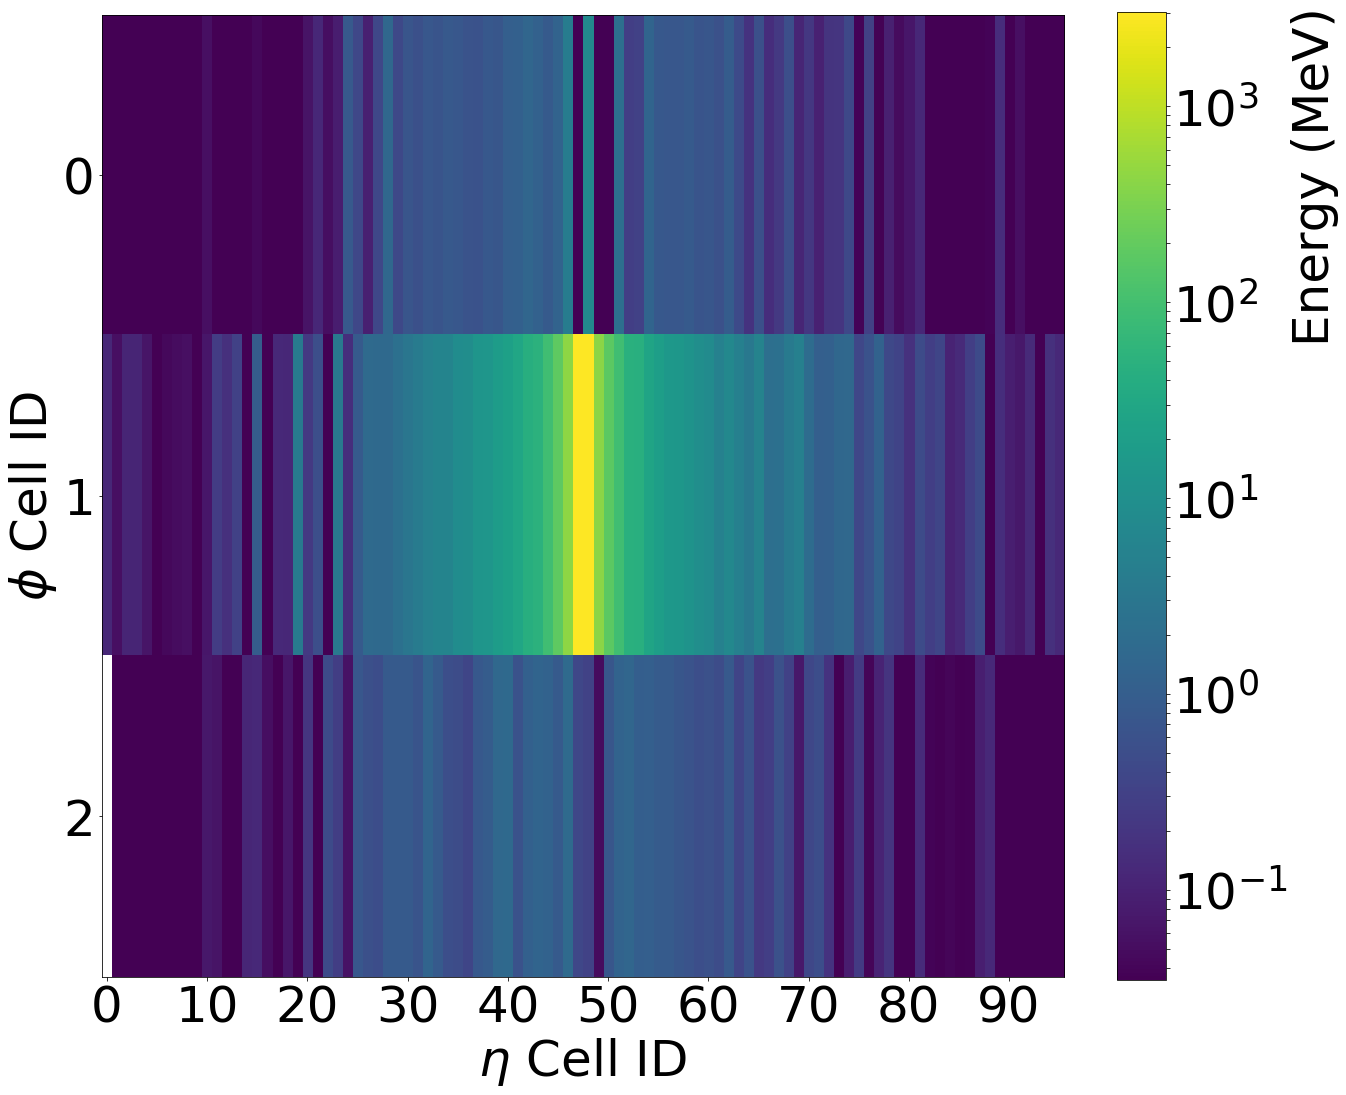

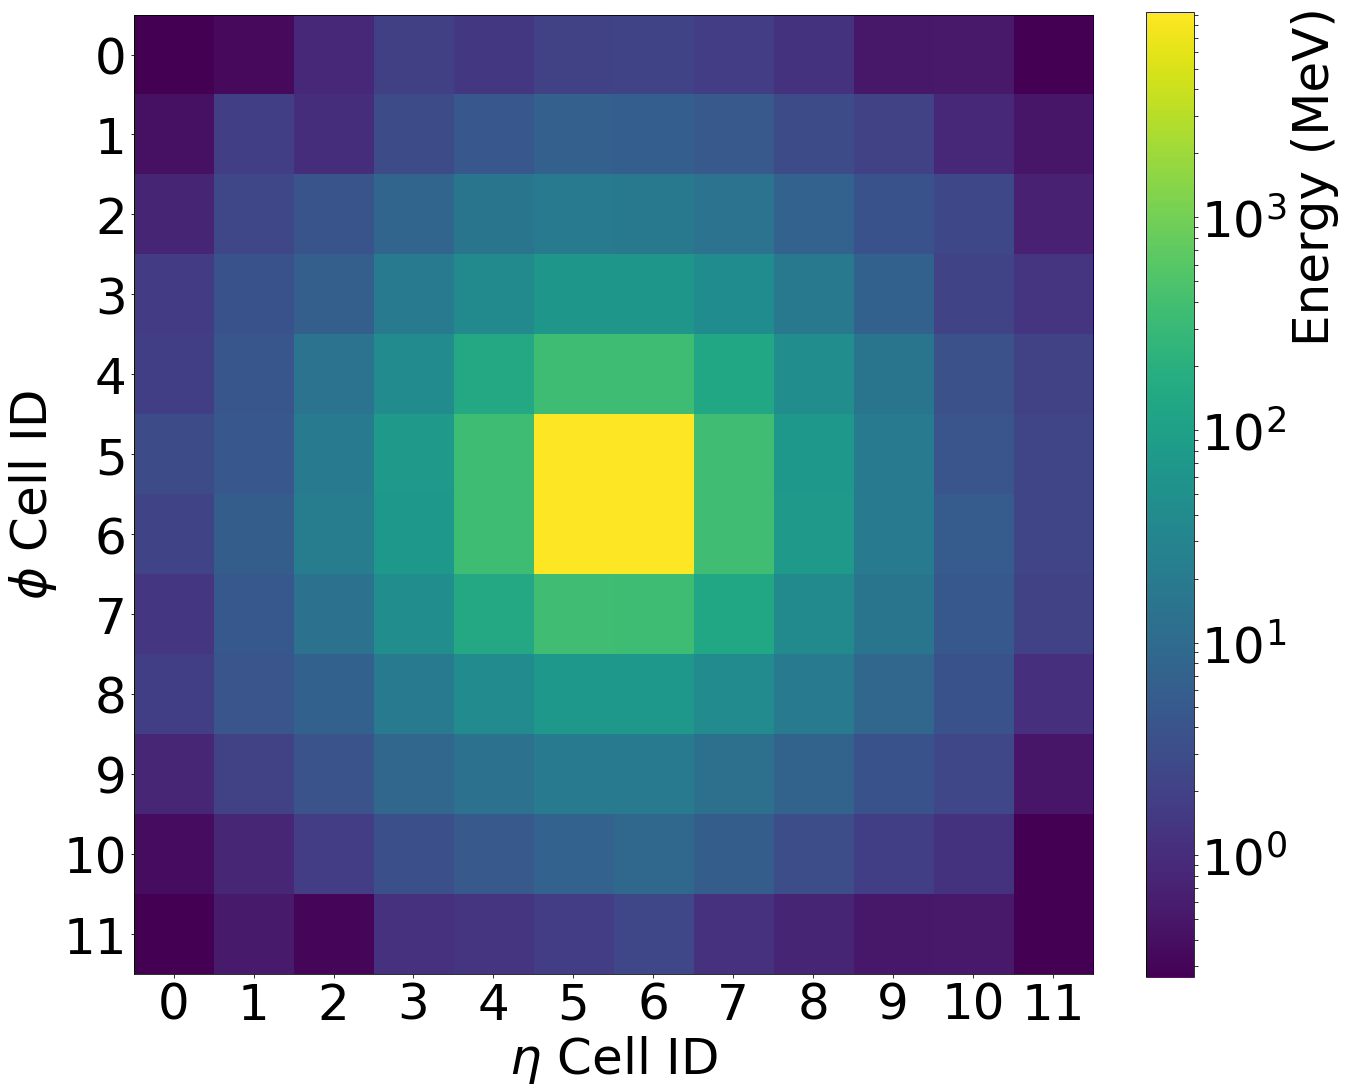

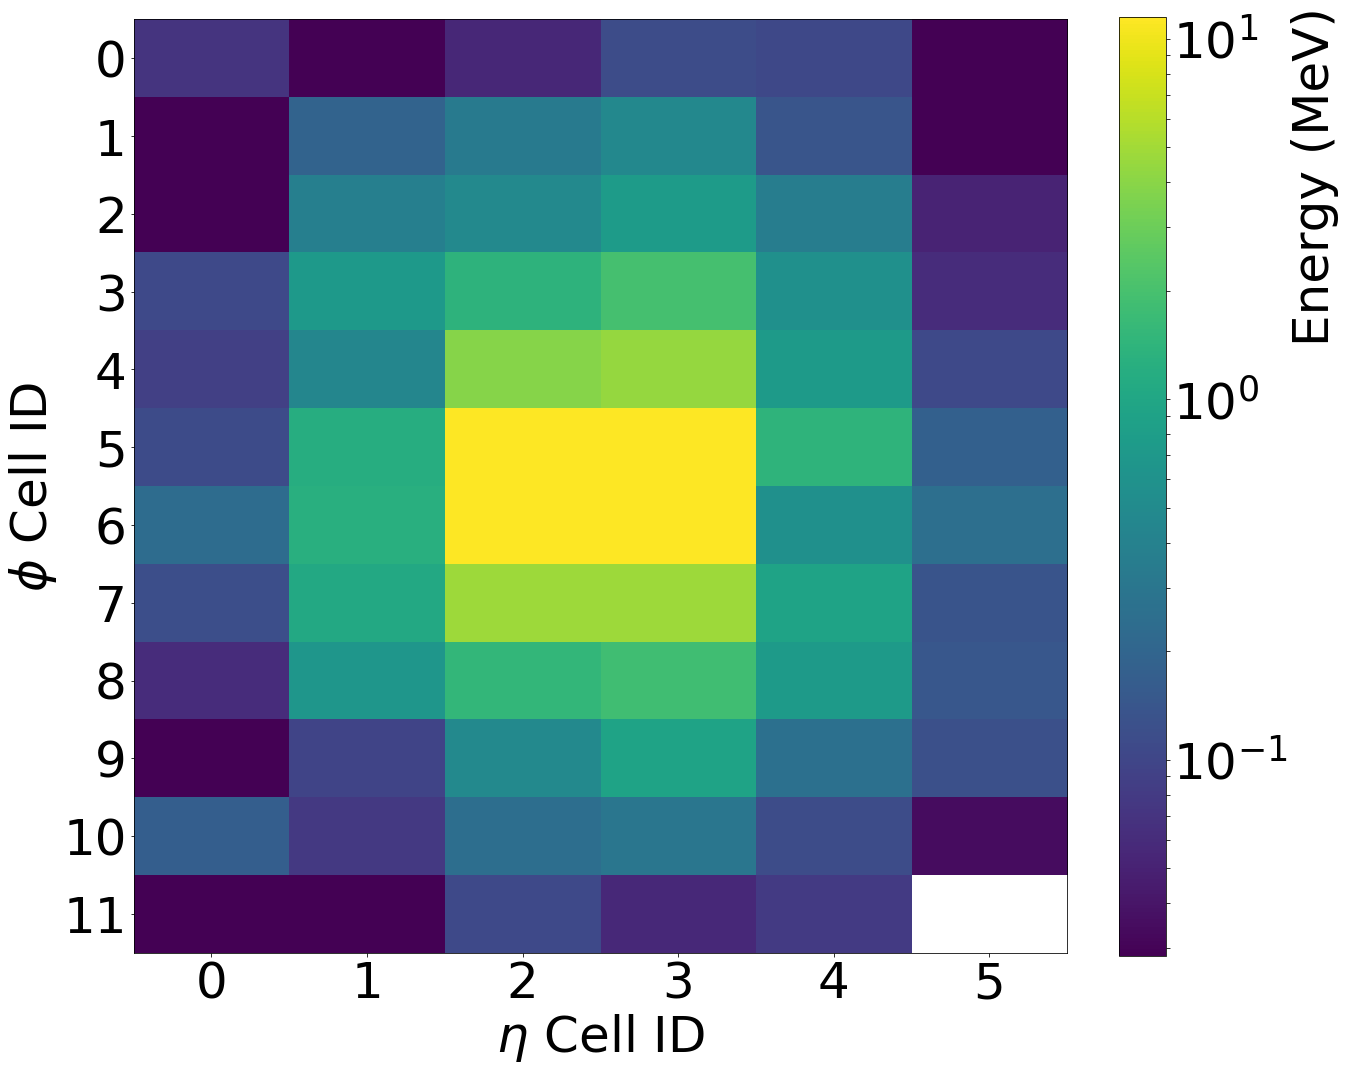

In [114]:
for i in xrange(3):
    plot_image(np.squeeze(gen_images[i]).mean(axis=0),
               layer=i,
               vmin=vmin[i],
               vmax=vmax[i]
    )
    plt.savefig('gamma_{}.pdf'.format(i), transparent=True)

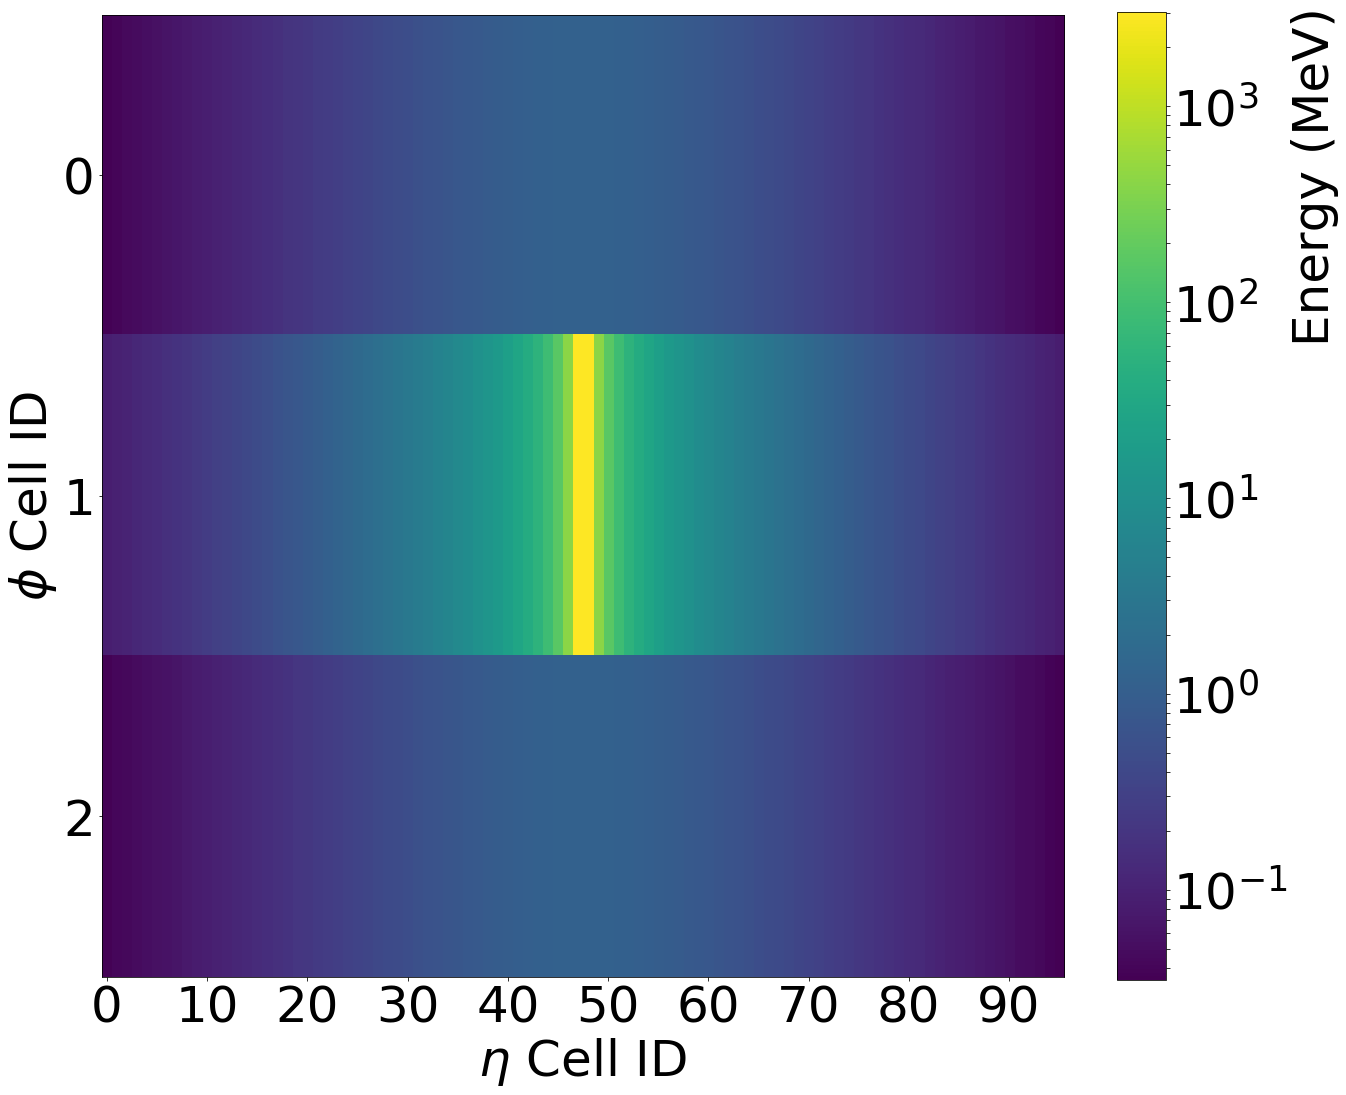

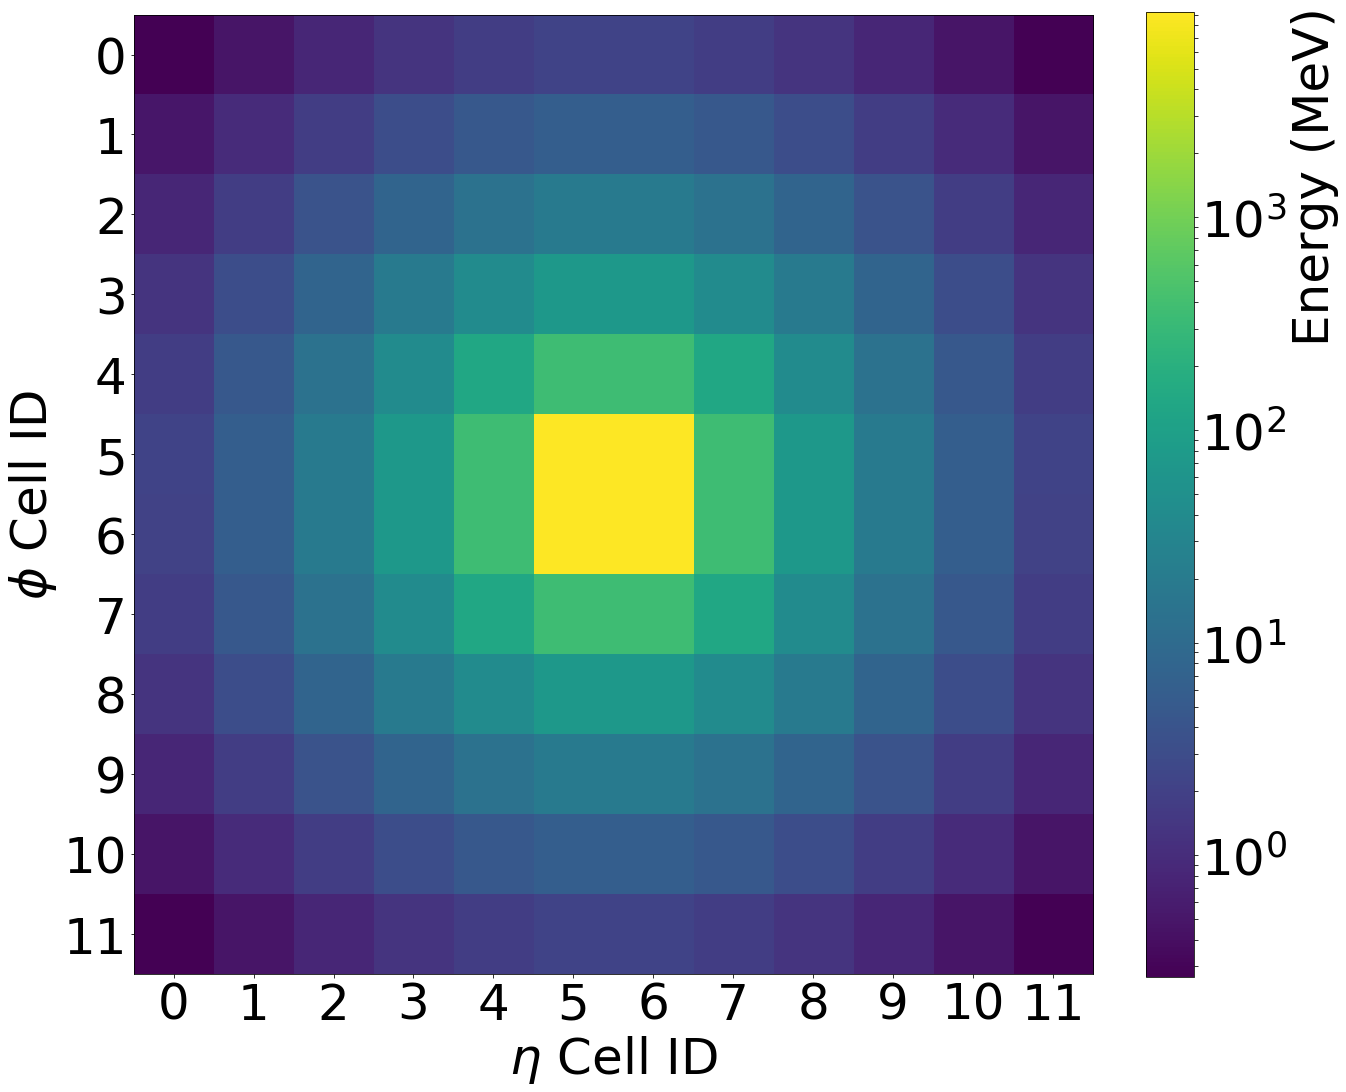

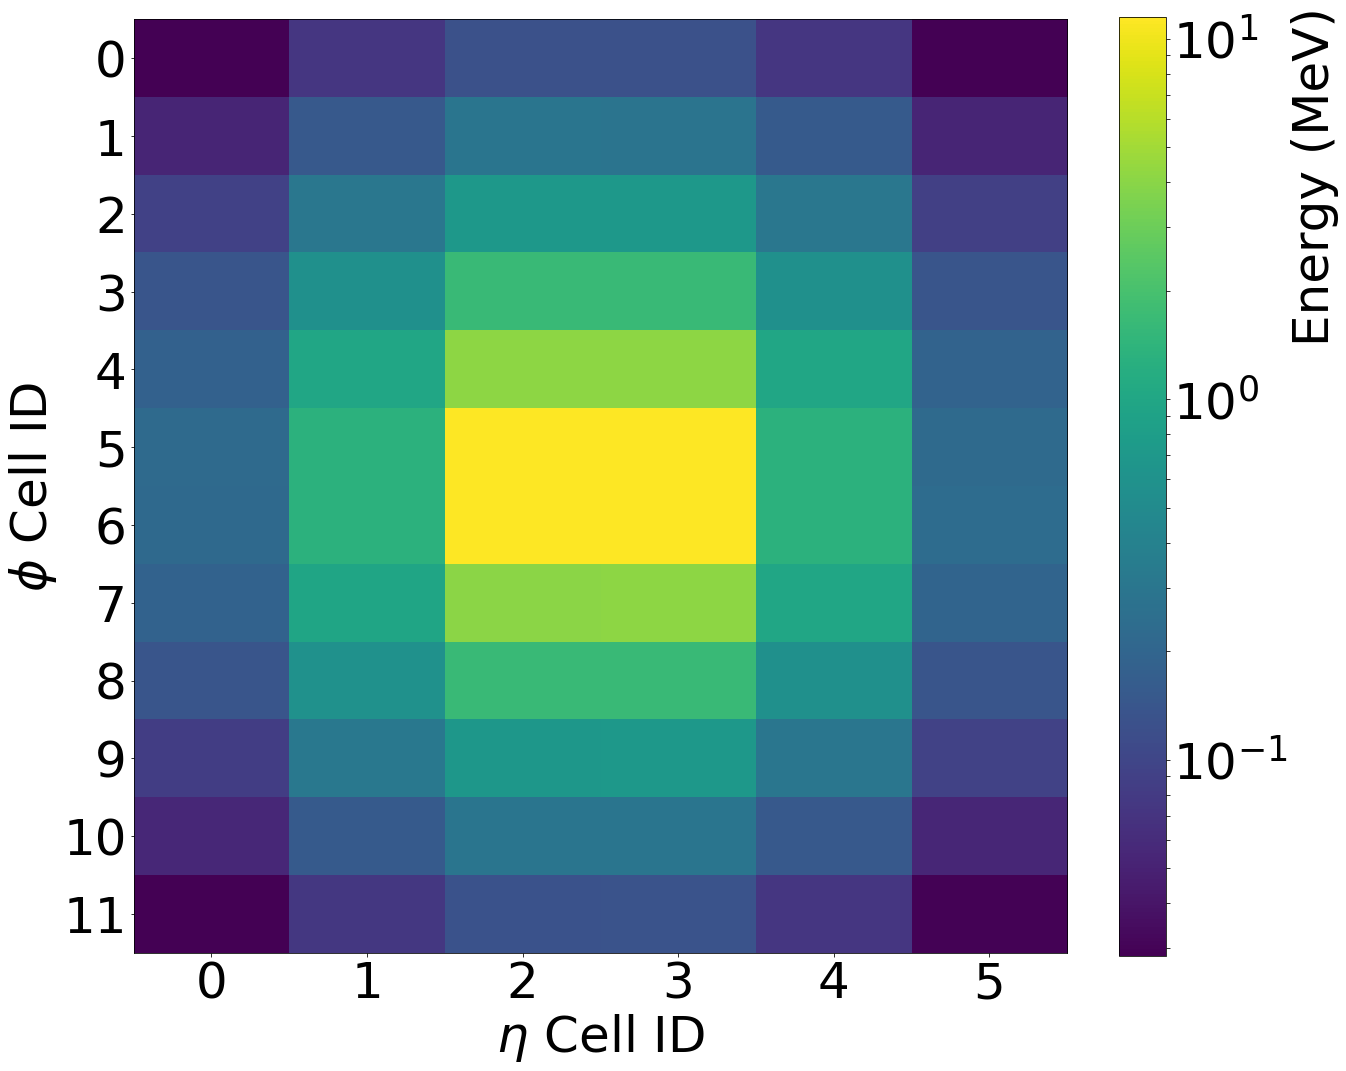

In [87]:
for i in xrange(3):
    plot_image(np.squeeze(real_images[i][:70000]).mean(axis=0), layer=i)
    plt.savefig('gamma_{}_geant.pdf'.format(i), transparent=True)

In [190]:
def plot_nn(layer, gen_images=gen_images, real_images=real_images, vmin=vmin, vmax=vmax, sizes=sizes, nparticles=5):
    '''
    vmin and vmax are the arrays defined above based on GEANT image ranges
    sizes is also defined above
    '''
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(1, metric='euclidean')
    nn.fit(gen_images[layer].reshape(gen_images[layer].shape[0], -1))
    f, axarr = plt.subplots(2, nparticles, figsize=(25, 10))
    particles = np.random.randint(low=0, high=real_images[layer].shape[0], size=nparticles)

    for i, sel in enumerate(particles):
        nbr = int(nn.kneighbors(real_images[layer][sel].ravel().reshape(1, -1))[-1])
        def _plot_im(n_row, images):
            im = axarr[n_row, i].imshow(images,
                                        interpolation='nearest',
                                        norm=LogNorm(vmin=vmin[layer], vmax=vmax[layer]),
                                        aspect=sizes[1+(layer*2)] / float(sizes[(0)+(layer*2)]),
                                       )
            axarr[n_row, i].tick_params(axis='both', which='both', bottom='off', top='off',
                                    left='off', right='off', labelbottom='off',
                                    labelleft='off')
            return im

        cnv = [_plot_im(*content) for content in enumerate([real_images[layer][sel], gen_images[layer][nbr]])]
    axarr[0][0].set_ylabel('GEANT')
    axarr[1][0].set_ylabel('GAN')
    cax = f.add_axes([0.93, 0.11, 0.03, 0.8])
    cb = f.colorbar(cnv[0], cax=cax)
    cb.set_label(r'Energy (MeV)', y=0.73)
    plt.savefig('nn{}.pdf'.format(layer), pad_inches=2, transparent=True, bbox_inches='tight')

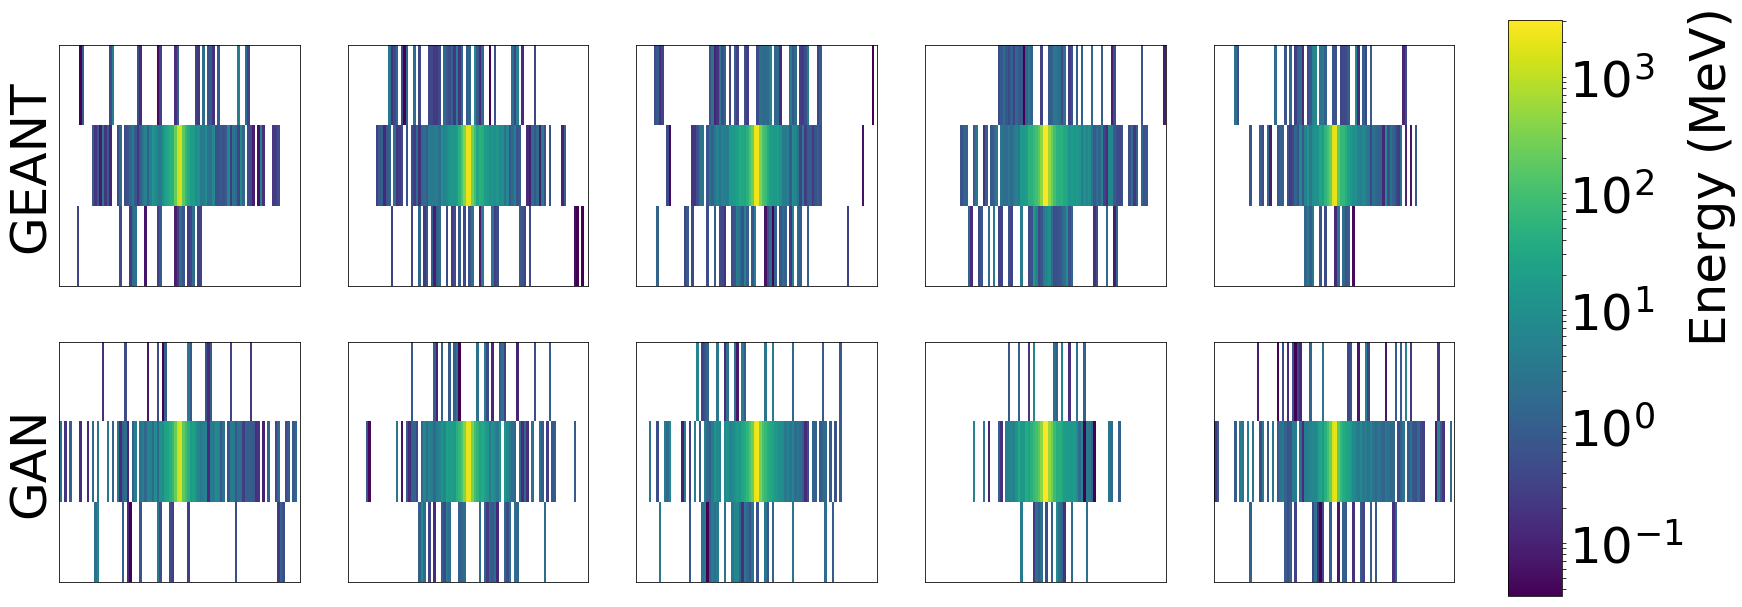

In [198]:
plot_nn(0)

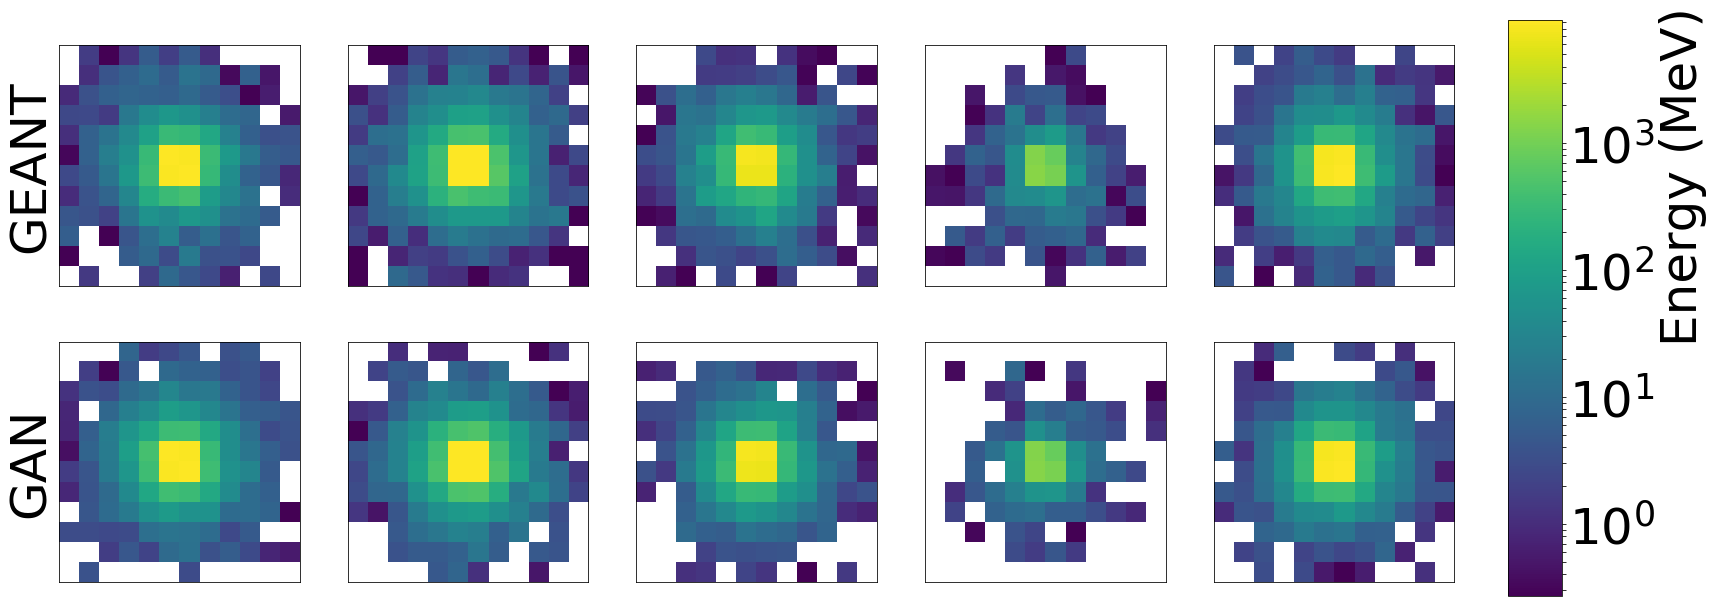

In [200]:
plot_nn(1)

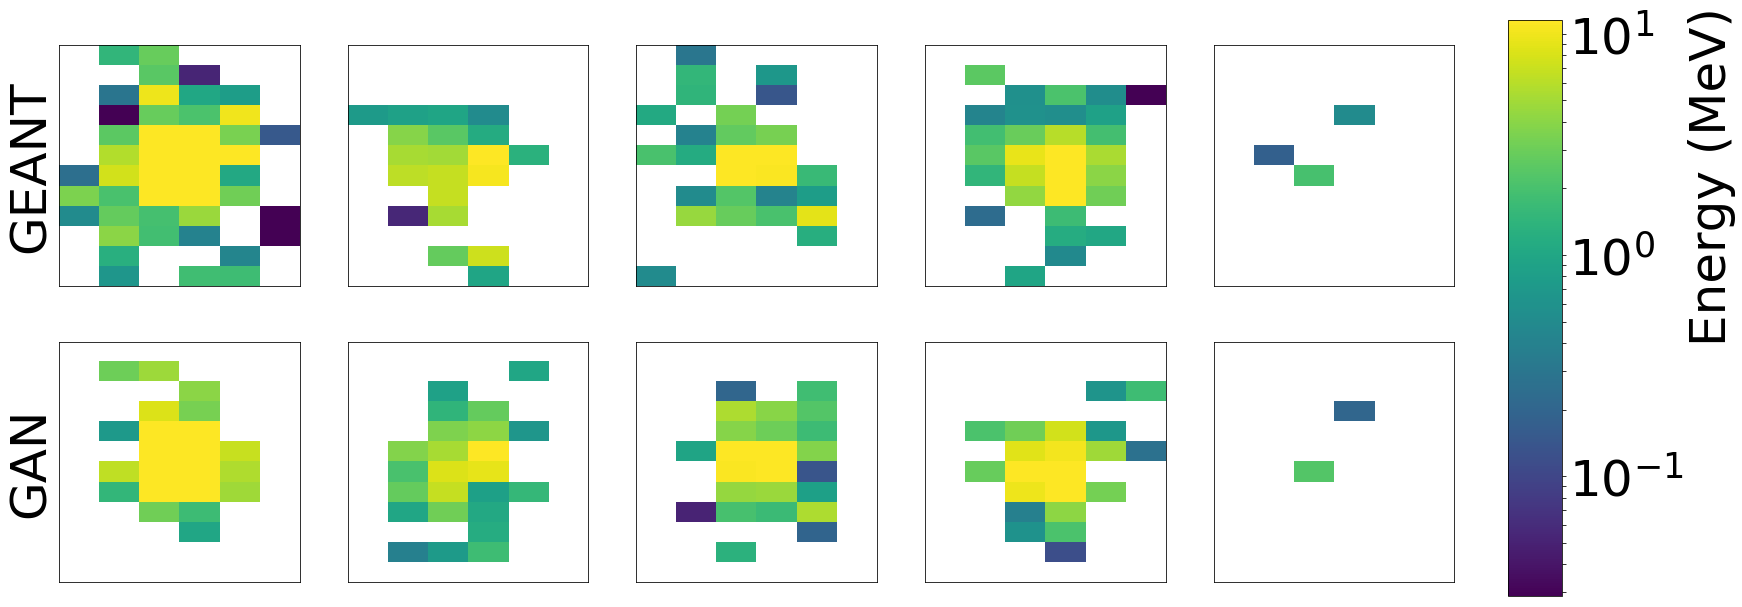

In [203]:
plot_nn(2)

In [197]:
from feats1d import *

In [204]:
dgen = {
    'layer_0' : np.squeeze(gen_images[0]),
    'layer_1' : np.squeeze(gen_images[1]),
    'layer_2' : np.squeeze(gen_images[2])
}

In [205]:
matplotlib.rcParams.update({'font.size': 40})

In [206]:
depth_orig = depth(d)
depth_gen = depth(dgen)

In [207]:
gen_sparsity = map(lambda x: (x > 0).mean((1, 2)), gen_images)
real_sparsity = map(lambda x: (x > 0).mean((1, 2)), real_images)

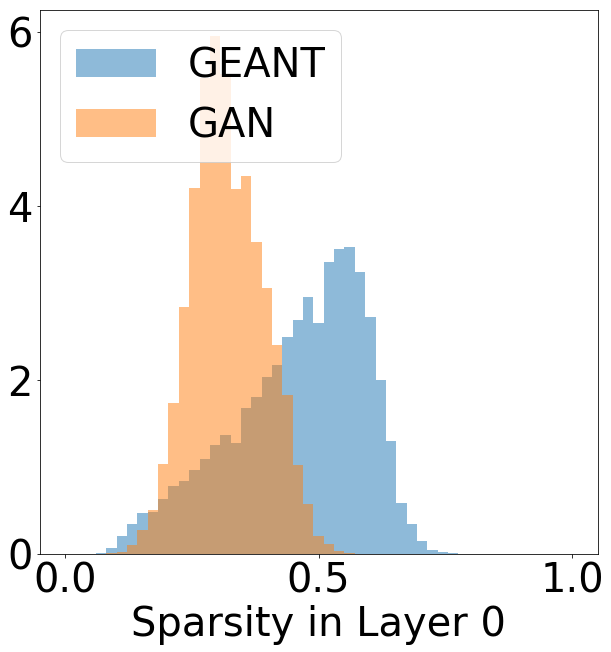

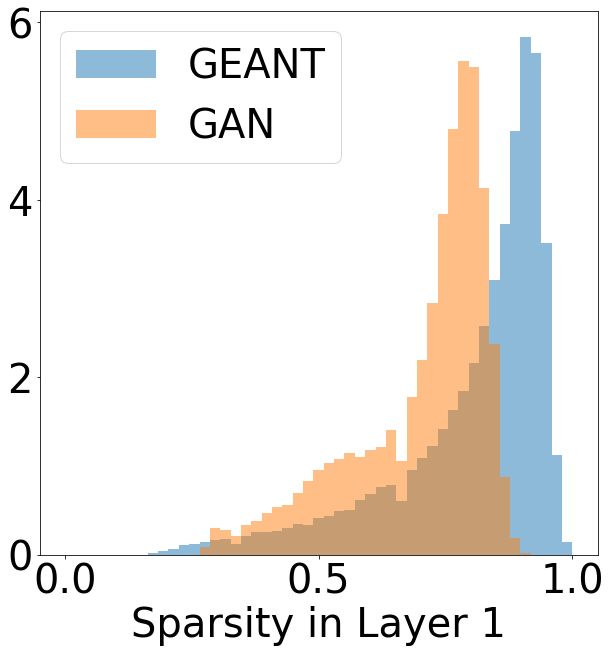

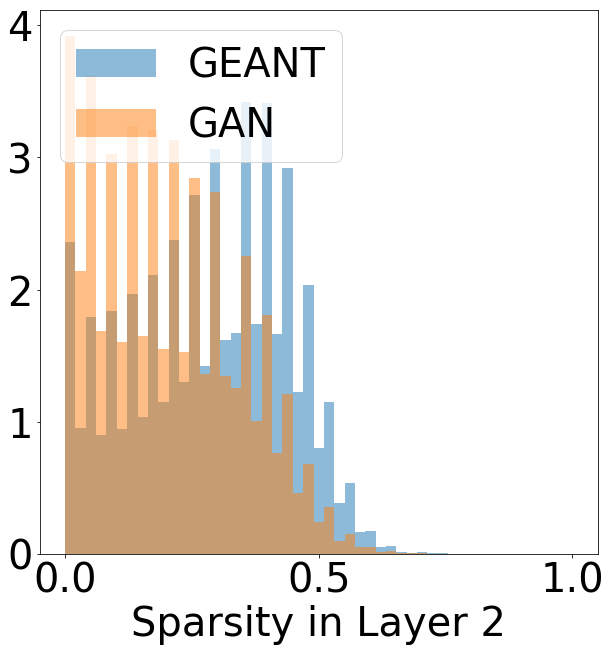

In [209]:
for i in xrange(3):
    bins = np.linspace(0, 1, 50)
    plt.figure(figsize=(10, 10))
    _ = plt.hist(real_sparsity[i], bins=bins, histtype='stepfilled', alpha=0.5, normed='True',
                 label='GEANT')
    _ = plt.hist(gen_sparsity[i], bins=bins, histtype='stepfilled', alpha=0.5, normed='True',
                 label='GAN')
    plt.legend(loc='upper left')
    plt.xlabel('Sparsity in Layer {}'.format(i))

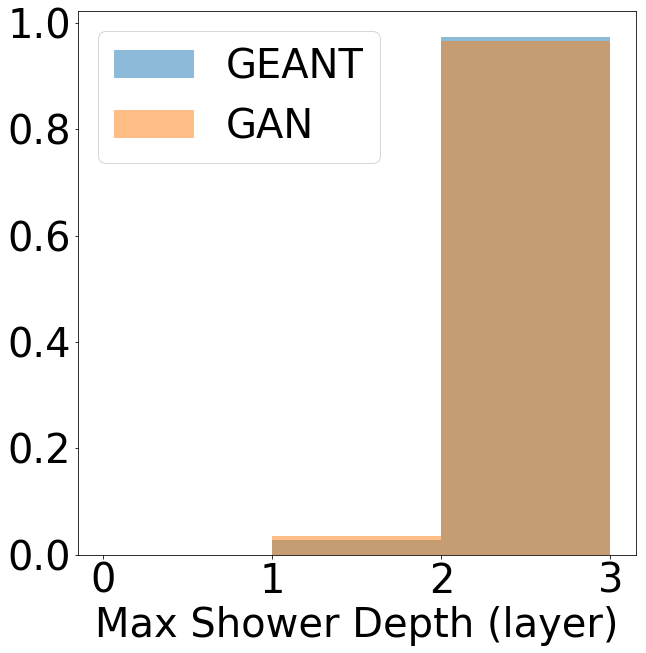

In [210]:
bins = [0, 1, 2, 3]
plt.figure(figsize=(10, 10))
_ = plt.hist(depth_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(depth_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left')
plt.xlabel('Max Shower Depth (layer)')

In [211]:
etot_orig = total_energy(d)
etot_gen = total_energy(dgen)

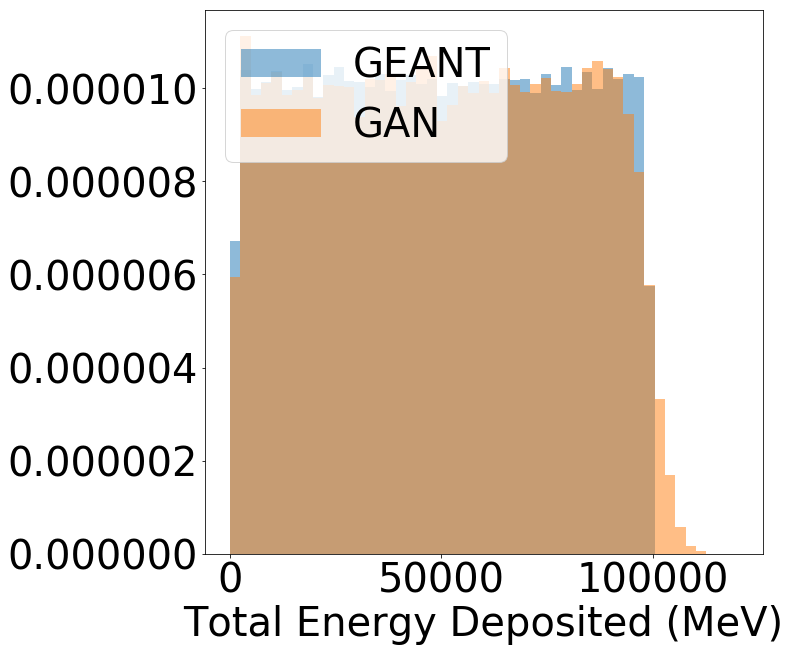

In [212]:
bins = np.linspace(100, 120000, 50)
# bins = np.linspace(70000, 75000, 50)
plt.figure(figsize=(10, 10))
_ = plt.hist(etot_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True',
             label='GEANT')
_ = plt.hist(etot_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True',
             label='GAN')
plt.legend(loc='upper left')
plt.xlabel('Total Energy Deposited (MeV)')

In [213]:
e2_orig = energy('2', d)
e2_gen = energy('2', dgen) 
e1_orig = energy('1', d)
e1_gen = energy('1', dgen) 
e0_orig = energy('0', d)
e0_gen = energy('0', dgen)

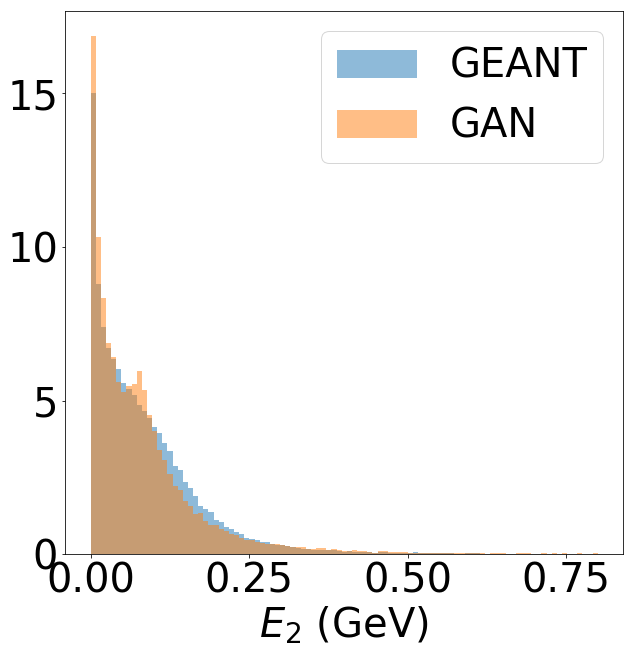

In [214]:
bins = np.linspace(0, 800, 100) / 1000
plt.figure(figsize=(10, 10))
_ = plt.hist(e2_orig / 1000, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(e2_gen / 1000, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')
plt.xlabel(r'$E_2$ (GeV)')

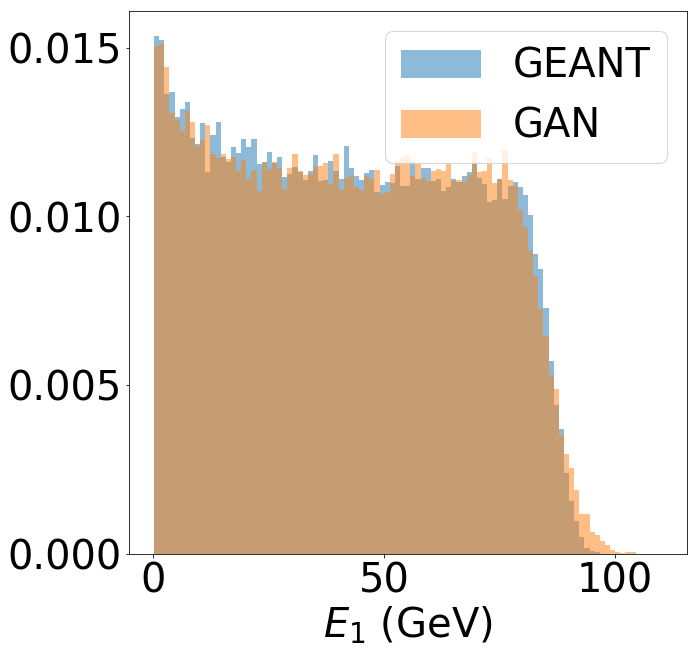

In [215]:
bins = np.linspace(300, 110000, 100)/1000
plt.figure(figsize=(10, 10))
_ = plt.hist(e1_orig/1000, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(e1_gen/1000, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')
plt.xlabel(r'$E_1$ (GeV)')

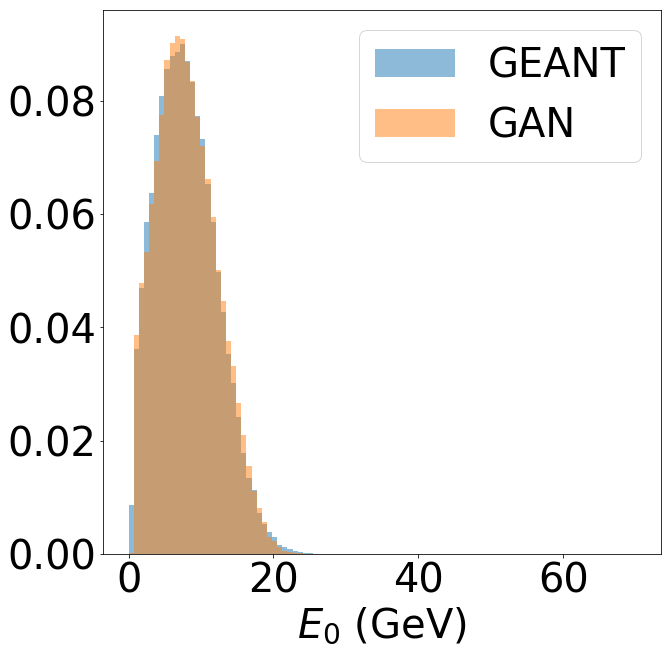

In [216]:
bins = np.linspace(0, 70000, 100)/1000
plt.figure(figsize=(10, 10))
_ = plt.hist(e0_orig/1000, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(e0_gen/1000, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')
plt.xlabel(r'$E_0$ (GeV)')

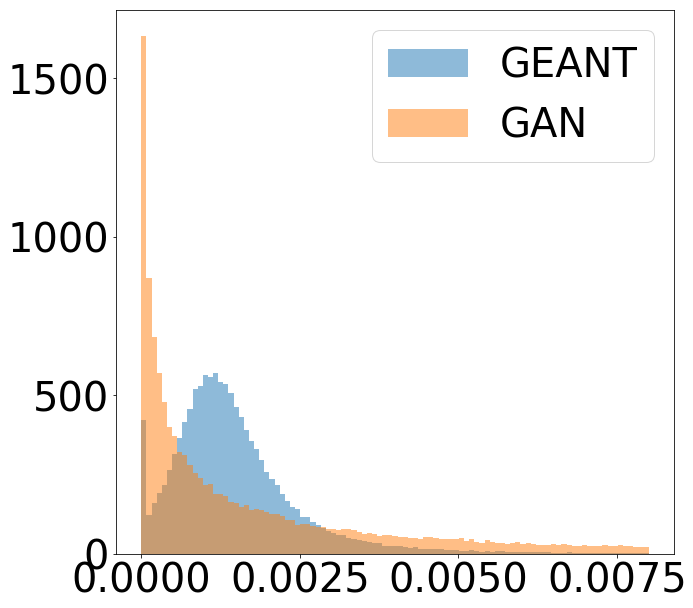

In [217]:
bins = np.linspace(0, 0.008, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e2_orig / etot_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(e2_gen / etot_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')

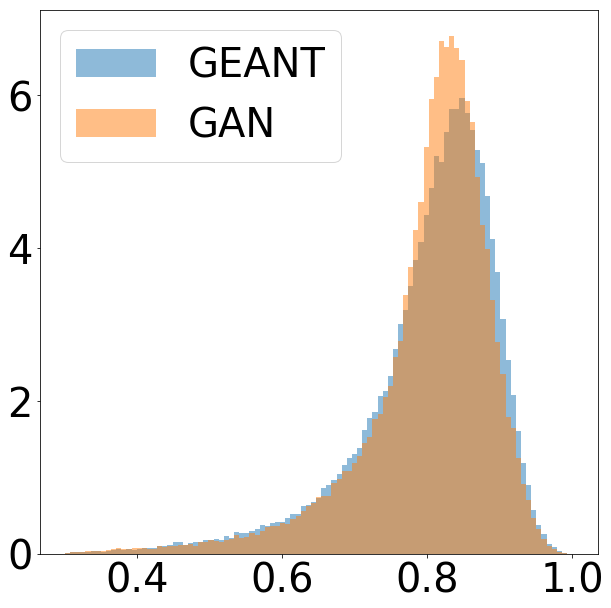

In [218]:
bins = np.linspace(0.3, 1, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e1_orig / etot_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(e1_gen / etot_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left')

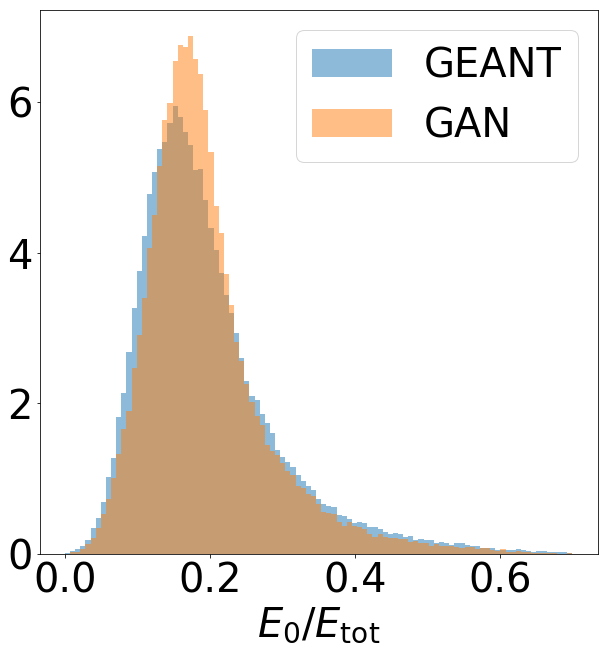

In [219]:
bins = np.linspace(0, 0.7, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e0_orig / etot_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(e0_gen / etot_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')
plt.xlabel(r'$E_0 / E_{\mathrm{tot}}$')

In [77]:
lateral_depth_orig = lateral_depth(d)
lateral_depth_gen = lateral_depth(dgen)

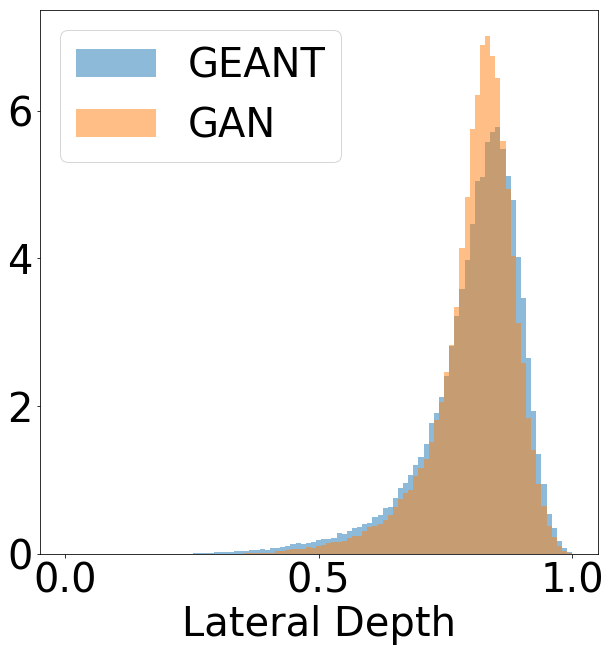

In [78]:
bins = np.linspace(0, 1, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(lateral_depth_orig / etot_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(lateral_depth_gen / etot_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left')
plt.xlabel('Lateral Depth')
# / E_tot

In [79]:
lateral_depth2_orig = lateral_depth2(d)
lateral_depth2_gen = lateral_depth2(dgen)

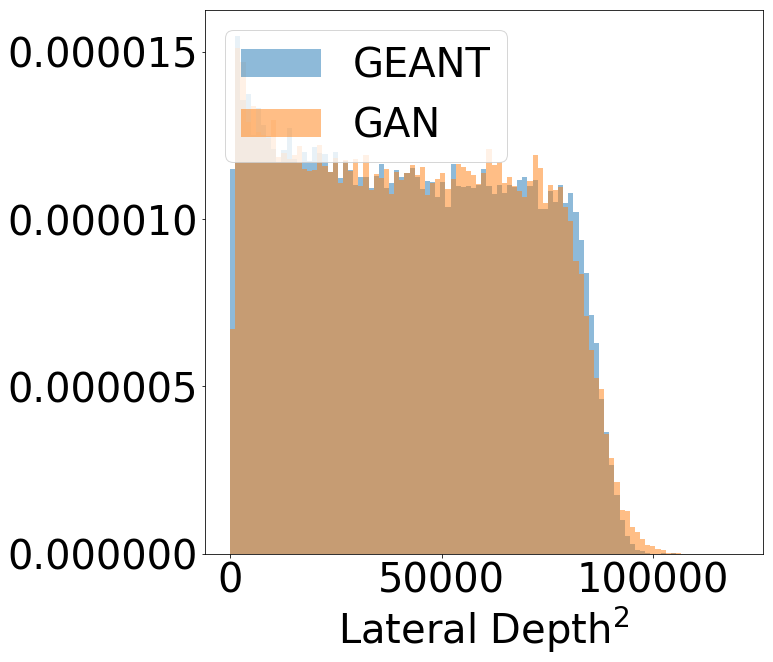

In [80]:
bins = np.linspace(0, 120000, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(lateral_depth2_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(lateral_depth2_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left')
plt.xlabel(r'Lateral Depth$^2$')

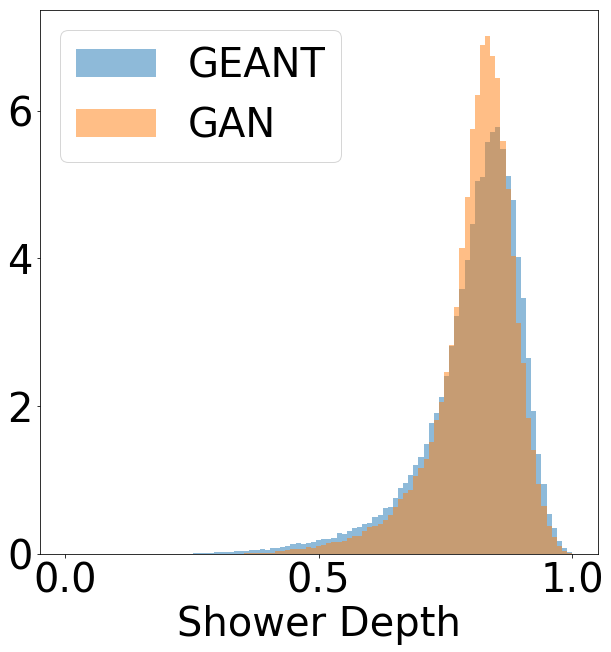

In [81]:
# shower depth
bins = np.linspace(0, 1, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(lateral_depth_orig / etot_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(lateral_depth_gen / etot_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left')
plt.xlabel('Shower Depth')

In [82]:
shower_depth_width_orig = shower_depth_width(
    lateral_depth_orig, lateral_depth2_orig, etot_orig)
shower_depth_width_gen = shower_depth_width(
    lateral_depth_gen, lateral_depth2_gen, etot_gen)

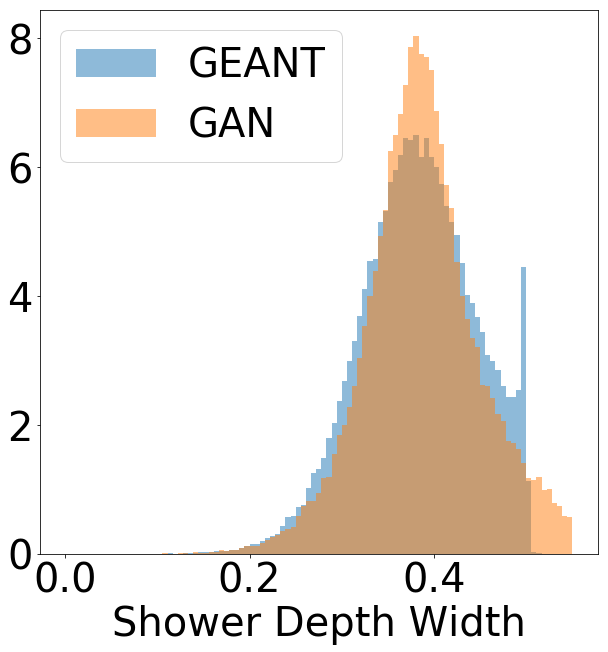

In [83]:
# shower depth width
bins = np.linspace(0, 0.55, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(shower_depth_width_orig , bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(shower_depth_width_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left')
plt.xlabel('Shower Depth Width')

In [84]:
lateral_width0_orig = layer_lateral_width('0', d)
lateral_width1_orig = layer_lateral_width('1', d)
lateral_width2_orig = layer_lateral_width('2', d)
lateral_width0_gen = layer_lateral_width('0', dgen)
lateral_width1_gen = layer_lateral_width('1', dgen)
lateral_width2_gen = layer_lateral_width('2', dgen)

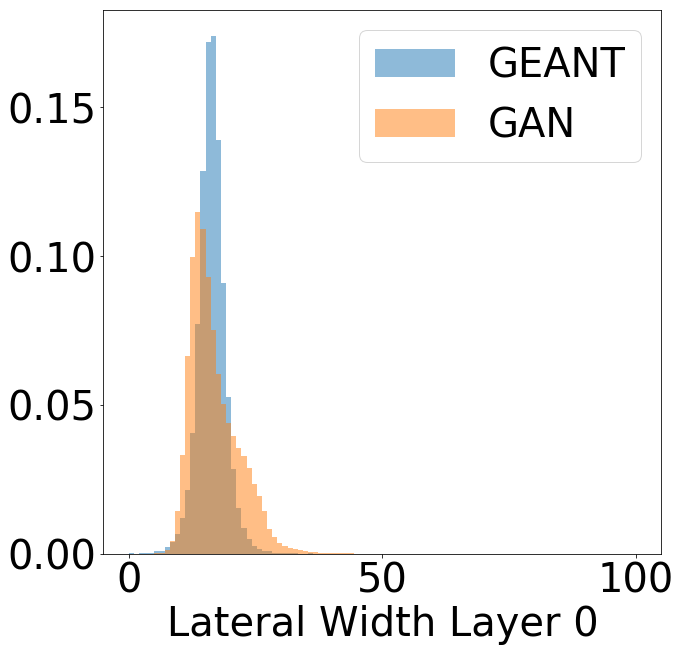

In [85]:
# layer 0 lateral width
bins = np.linspace(0, 100, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(lateral_width0_orig , bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(lateral_width0_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')
plt.xlabel('Lateral Width Layer 0')

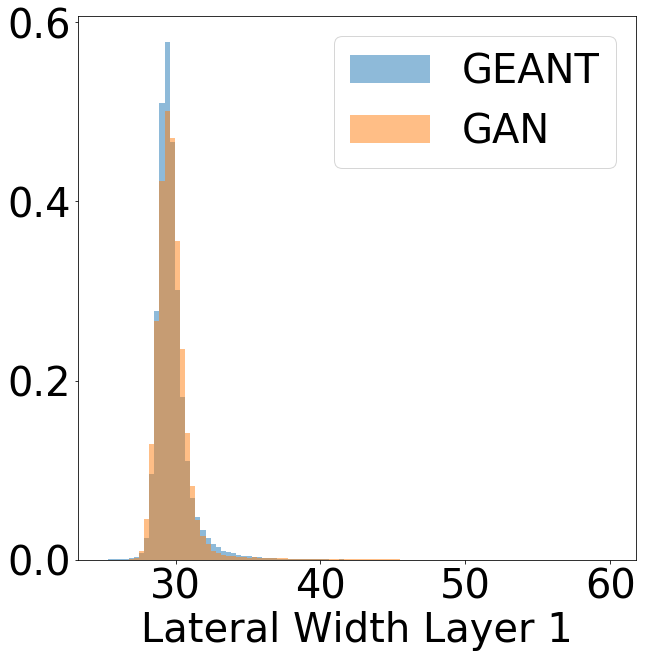

In [86]:
# layer 1 lateral width
bins = np.linspace(25, 60, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(lateral_width1_orig , bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(lateral_width1_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')
plt.xlabel('Lateral Width Layer 1')

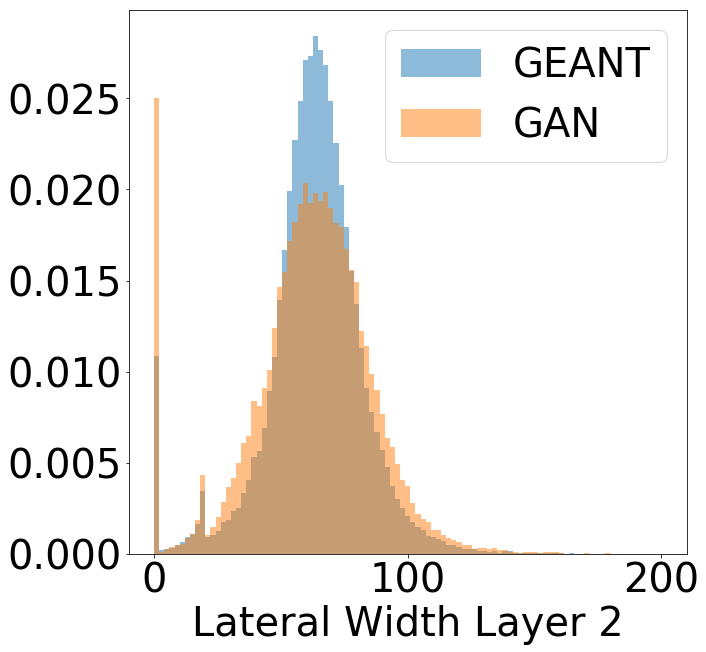

In [87]:
# layer 2 lateral width
bins = np.linspace(0, 200, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(lateral_width2_orig[np.isfinite(lateral_width2_orig)] , bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(lateral_width2_gen[np.isfinite(lateral_width2_gen)], bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')
plt.xlabel('Lateral Width Layer 2')